In [ ]:
import pandas as pd
import numpy as np
import time
import logging
from sqlalchemy import create_engine
import os
from google.colab import drive

# Configure logging
logging.basicConfig(
    filename="logs/ingestion_db.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# Database engine
engine = create_engine('sqlite:///inventory.db')

# Mount Google Drive
drive.mount('/content/drive')

# Path to your data folder inside Drive
data_path = "/content/drive/My Drive/vendor_performance/data"

def ingest_db(df, table_name, engine):
    """This function will ingest the dataframe into database table"""
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

def load_raw_data():
    """This function will load the csv as dataframe and ingest into db"""
    start = time.time()

    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(data_path, file))
            logging.info(f'Ingesting {file} into db')
            ingest_db(df, file[:-4], engine)

    end = time.time()
    total_time = (end - start) / 60
    logging.info('Ingestion complete')
    logging.info(f'Total Time Taken: {total_time:.2f} minutes')

if __name__ == '__main__':
    load_raw_data()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import time
import logging
from sqlalchemy import create_engine
import os
from google.colab import drive

# Ensure logs folder exists
os.makedirs("logs", exist_ok=True)

# Configure logging
logging.basicConfig(
    filename="logs/ingestion_db.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# Database engine
engine = create_engine('sqlite:///inventory.db')

# Mount Google Drive
drive.mount('/content/drive')

# Path to your data folder inside Drive
data_path = "/content/drive/My Drive/vendor_performance/data"

def ingest_db(file_path, table_name, engine, chunksize=50000):
    """Ingest CSV into database in chunks to avoid memory issues"""
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk.to_sql(table_name, con=engine, if_exists='append', index=False)

def load_raw_data():
    """This function will load the csv as dataframe and ingest into db"""
    start = time.time()

    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            file_path = os.path.join(data_path, file)
            logging.info(f'Ingesting {file} into db in chunks')
            ingest_db(file_path, file[:-4], engine)

    end = time.time()
    total_time = (end - start) / 60
    logging.info('Ingestion complete')
    logging.info(f'Total Time Taken: {total_time:.2f} minutes')

if __name__ == '__main__':
    load_raw_data()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#final ingestion
import pandas as pd
import time
import logging
from sqlalchemy import create_engine
import os
from google.colab import drive

# Ensure logs folder exists
os.makedirs("logs", exist_ok=True)

# Configure logging
logging.basicConfig(
    filename="logs/ingestion_db.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# Database engine
engine = create_engine('sqlite:///inventory.db')

# Mount Google Drive
drive.mount('/content/drive')

# Path to your data folder inside Drive
data_path = "/content/drive/My Drive/vendor_performance/data"

def ingest_db(file_path, table_name, engine, chunksize=50000):
    """Ingest large CSV into database in chunks with deduplication"""
    seen_chunks = []  # store deduped chunks temporarily

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk = chunk.drop_duplicates()
        seen_chunks.append(chunk)

    # Concatenate all chunks and drop duplicates across them
    df_final = pd.concat(seen_chunks).drop_duplicates()

    logging.info(f"Final row count for {table_name}: {len(df_final)} (after dropping duplicates)")
    df_final.to_sql(table_name, con=engine, if_exists='replace', index=False)

def load_raw_data():
    """Load CSVs in chunks, clean, and ingest into db"""
    start = time.time()

    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            file_path = os.path.join(data_path, file)

            logging.info(f'Starting ingestion for {file}')
            ingest_db(file_path, file[:-4], engine)

    end = time.time()
    total_time = (end - start) / 60
    logging.info('Ingestion complete')
    logging.info(f'Total Time Taken: {total_time:.2f} minutes')

if __name__ == '__main__':
    load_raw_data()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# final ingestion (fixed for memory efficiency)
import pandas as pd
import time
import logging
from sqlalchemy import create_engine, text
import os
from google.colab import drive

# Ensure logs folder exists
os.makedirs("logs", exist_ok=True)

# Configure logging
logging.basicConfig(
    filename="logs/ingestion_db.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# Database engine
engine = create_engine('sqlite:///inventory.db')

# Mount Google Drive
drive.mount('/content/drive')

# Path to your data folder inside Drive
data_path = "/content/drive/My Drive/vendor_performance/data"

def ingest_db(file_path, table_name, engine, chunksize=50000):
    """Ingest large CSV into database in chunks, deduplicate using SQL"""
    staging_table = f"{table_name}_staging"

    with engine.begin() as conn:
        # Drop staging if it already exists
        conn.execute(text(f"DROP TABLE IF EXISTS {staging_table}"))

    # Load CSV in chunks into staging table
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk.to_sql(staging_table, con=engine, if_exists='append', index=False)

    with engine.begin() as conn:
        # Replace final table with deduplicated rows from staging
        conn.execute(text(f"DROP TABLE IF EXISTS {table_name}"))
        conn.execute(text(f"""
            CREATE TABLE {table_name} AS
            SELECT DISTINCT * FROM {staging_table}
        """))
        conn.execute(text(f"DROP TABLE {staging_table}"))

    logging.info(f"Ingestion complete for {table_name} (deduplicated in DB)")

def load_raw_data():
    """Load CSVs in chunks, clean, and ingest into db"""
    start = time.time()

    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            file_path = os.path.join(data_path, file)
            table_name = file[:-4]
            logging.info(f'Starting ingestion for {file}')
            ingest_db(file_path, table_name, engine)

    end = time.time()
    total_time = (end - start) / 60
    logging.info('Ingestion complete')
    logging.info(f'Total Time Taken: {total_time:.2f} minutes')

if __name__ == '__main__':
    load_raw_data()


Mounted at /content/drive


**EXPLORATORY DATA ANALYSIS**

understanding the datataset to explore how the data is present in the database and if there is a need of creating some aggregarted tables that can help with:

1. vendor selection for profitability
2. product pricing optimization

In [2]:
import pandas as pd
import sqlite3


In [3]:
#creating database connection
conn=sqlite3.connect('inventory.db')

In [4]:
#checking the tables present in the database
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    engine
)
print(tables)


              name
0   vendor_invoice
1  purchase_prices
2        purchases
3  begin_inventory
4    end_inventory
5            sales


In [5]:
for table in tables['name']:
    print('-' * 50, f'{table}', '-' * 50)

    # Get row count
    count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table}", engine)['count'].values[0]
    print('count of records:', count)

    # Preview first 5 rows
    display(pd.read_sql(f"SELECT * FROM {table} LIMIT 5", engine))


-------------------------------------------------- vendor_invoice --------------------------------------------------
count of records: 5543


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,None
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,None
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,None


-------------------------------------------------- purchase_prices --------------------------------------------------
count of records: 12261


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


-------------------------------------------------- purchases --------------------------------------------------
count of records: 2372474


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5,106.60,1


-------------------------------------------------- begin_inventory --------------------------------------------------
count of records: 206529


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


-------------------------------------------------- end_inventory --------------------------------------------------
count of records: 224489


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


-------------------------------------------------- sales --------------------------------------------------
count of records: 12825363


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2024-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2024-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2024-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [6]:
purchases=pd.read_sql_query("SELECT * from purchases where VendorNumber=4466",conn)
purchases

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
1,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
2,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
3,38_GOULCREST_5215,38,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-07,2024-01-19,2024-02-26,9.41,6,56.46,1
4,59_CLAETHORPES_5215,59,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-05,2024-01-19,2024-02-26,9.41,6,56.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,81_PEMBROKE_5215,81,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-29,2025-01-04,2025-02-10,9.41,6,56.46,1
2188,62_KILMARNOCK_5255,62,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.35,5,46.75,1
2189,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.41,5,47.05,1
2190,6_GOULCREST_5215,6,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-31,2025-01-04,2025-02-10,9.41,6,56.46,1


In [7]:
purchase_prices=pd.read_sql_query("""SELECT * from purchase_prices where VendorNumber=4466""",conn)
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,5215,TGI Fridays Long Island Iced,12.99,1750mL,1750,1,9.41,4466,AMERICAN VINTAGE BEVERAGE
1,5255,TGI Fridays Ultimte Mudslide,12.99,1750mL,1750,1,9.35,4466,AMERICAN VINTAGE BEVERAGE
2,3140,TGI Fridays Orange Dream,14.99,1750mL,1750,1,11.19,4466,AMERICAN VINTAGE BEVERAGE


In [8]:
vendor_invoice=pd.read_sql_query("SELECT * from vendor_invoice where VendorNumber=4466",conn)
vendor_invoice

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-19,8207,2023-12-27,2024-02-26,335,3142.33,16.97,None
2,4466,AMERICAN VINTAGE BEVERAGE,2024-01-18,8307,2024-01-03,2024-02-18,41,383.35,1.99,None
3,4466,AMERICAN VINTAGE BEVERAGE,2024-01-27,8469,2024-01-14,2024-03-11,72,673.20,3.30,None
4,4466,AMERICAN VINTAGE BEVERAGE,2024-02-04,8532,2024-01-19,2024-03-15,79,740.21,3.48,None
5,4466,AMERICAN VINTAGE BEVERAGE,2024-02-09,8604,2024-01-24,2024-03-15,347,3261.37,17.61,None
6,4466,AMERICAN VINTAGE BEVERAGE,2024-02-17,8793,2024-02-05,2024-04-02,72,675.36,3.17,None
7,4466,AMERICAN VINTAGE BEVERAGE,2024-03-01,8892,2024-02-12,2024-03-28,117,1096.05,5.15,None
8,4466,AMERICAN VINTAGE BEVERAGE,2024-03-07,8995,2024-02-19,2024-04-02,129,1209.27,5.44,None
9,4466,AMERICAN VINTAGE BEVERAGE,2024-03-12,9033,2024-02-22,2024-04-16,147,1377.87,6.61,None


In [9]:
sales=pd.read_sql_query("SELECT * from sales where VendorNo=4466",conn)
sales

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
1,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-12,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
2,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-15,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
3,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
4,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9448,9_BLACKPOOL_5215,9,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-12-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9449,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-02,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9450,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9451,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE


In [10]:
table = "purchase_prices"   # change to your table name
df = pd.read_sql(f"SELECT * FROM {table}", engine)

print("Total rows:", len(df))
print("Unique rows:", len(df.drop_duplicates()))

if len(df) != len(df.drop_duplicates()):
    print("Duplicates exist inside the CSV itself.")
else:
    print("No duplicates from ingestion.")


Total rows: 12261
Unique rows: 12261
No duplicates from ingestion.


In [11]:
purchases.groupby(['Brand','PurchasePrice'])[['Quantity','Dollars']].sum()

,,Quantity,Dollars
Brand,PurchasePrice,,
3140,11.19,4640,51921.60
5215,9.41,4923,46325.43
5255,9.35,6215,58110.25


In [12]:
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,5215,TGI Fridays Long Island Iced,12.99,1750mL,1750,1,9.41,4466,AMERICAN VINTAGE BEVERAGE
1,5255,TGI Fridays Ultimte Mudslide,12.99,1750mL,1750,1,9.35,4466,AMERICAN VINTAGE BEVERAGE
2,3140,TGI Fridays Orange Dream,14.99,1750mL,1750,1,11.19,4466,AMERICAN VINTAGE BEVERAGE


In [13]:
vendor_invoice['PONumber'].nunique()

55

In [14]:
vendor_invoice.shape

(55, 10)

if both are same that means po number is unique

In [15]:
purchases

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
1,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
2,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
3,38_GOULCREST_5215,38,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-07,2024-01-19,2024-02-26,9.41,6,56.46,1
4,59_CLAETHORPES_5215,59,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-05,2024-01-19,2024-02-26,9.41,6,56.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,81_PEMBROKE_5215,81,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-29,2025-01-04,2025-02-10,9.41,6,56.46,1
2188,62_KILMARNOCK_5255,62,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.35,5,46.75,1
2189,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.41,5,47.05,1
2190,6_GOULCREST_5215,6,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-31,2025-01-04,2025-02-10,9.41,6,56.46,1


In [16]:
sales.groupby('Brand')[['SalesDollars','SalesPrice','SalesQuantity']].sum()

,SalesDollars,SalesPrice,SalesQuantity
Brand,,,
3140,50531.10,30071.85,3890
5215,60416.49,41542.02,4651
5255,79187.04,51180.60,6096


1. The purchases table contains actual purchase data, including the date of purchase , products purchased by vendors, the amount paid(in dollars), ans the quantity purchased
2. the purchase price column is derived from the purchase_prices table , which provides product wise actual and purchase prices. the combination of vendor and brand is unique in this table.
3. the vendor_invoice table aggregates data from the purchases table, summarizing quantity and dollar amounts , along with an additional column for freight. this table maintains uniqueness based on vendor and po number.
4. the sales table captures actual sales transactions , detailing the brands purchased by vendors , the quantity sold, the selling price , and the revenue earned.

as the data that we need for analysis is distributed in different tables, we need to create a summary table containing:
1. purchase transactions made by vendors
2. sales transaction data
3. freight cost of each vendor
4. actual product prices from vendors

In [17]:
vendor_invoice.columns

Index(['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate',
       'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval'],
      dtype='object')

In [18]:
freight_summary=pd.read_sql_query(
    """select  VendorNumber,SUM(Freight) as FreightCost FROM vendor_invoice GROUP BY VendorNumber""",conn
)

In [19]:
freight_summary

,VendorNumber,FreightCost
0,2,27.08
1,54,0.48
2,60,367.52
3,105,62.39
4,200,6.19
...,...,...
121,98450,856.02
122,99166,130.09
123,172662,178.34
124,173357,202.50


in the purchases_prices we have actual price and in the puchases we have quantity purchased, purchase price, Dollars . we need to do diff btw actual and purchased price

In [20]:
pd.read_sql_query("""select p.VendorNumber,p.VendorName,p.Brand,p.PurchasePrice,pp.Volume,pp.Price as ActualPrice,SUM(p.Quantity) as TotalPurchaseQuantity,SUM(p.Dollars)as TotalPurchaseDollars FROM purchases p JOIN purchase_prices pp ON p.Brand=pp.Brand  WHERE p.PurchasePrice>0 GROUP BY p.VendorNumber,p.VendorName,p.Brand ORDER BY TotalPurchaseDollars""",conn)

,VendorNumber,VendorName,Brand,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars
0,7245,PROXIMO SPIRITS INC.,3065,0.71,50,0.99,1,0.71
1,3960,DIAGEO NORTH AMERICA INC,6127,1.47,200,1.99,1,1.47
2,3924,HEAVEN HILL DISTILLERIES,9123,0.74,50,0.99,2,1.48
3,8004,SAZERAC CO INC,5683,0.39,50,0.49,6,2.34
4,9815,WINE GROUP INC,8527,1.32,750,4.99,2,2.64
...,...,...,...,...,...,...,...,...
10687,3960,DIAGEO NORTH AMERICA INC,3545,21.89,1750,29.99,138109,3023206.01
10688,3960,DIAGEO NORTH AMERICA INC,4261,16.17,1750,22.99,201682,3261197.94
10689,17035,PERNOD RICARD USA,8068,18.24,1750,24.99,187407,3418303.68
10690,4425,MARTIGNETTI COMPANIES,3405,23.19,1750,28.99,164038,3804041.22


In [21]:
sales.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

In [22]:
pd.read_sql_query("""SELECT VendorNo,Brand,SUM(SalesDollars) as TotalSalesDollars,SUM(SalesPrice) as TotalSalesPrice,SUM(SalesQuantity) as TotalSalesQuantity,SUM(ExciseTax) as TotalExciseTax FROM sales GROUP BY VendorNo,Brand ORDER BY TotalSalesDollars""",conn)

,VendorNo,Brand,TotalSalesDollars,TotalSalesPrice,TotalSalesQuantity,TotalExciseTax
0,8004,5287,9.800000e-01,0.98,2,0.10
1,9206,2773,9.900000e-01,0.99,1,0.05
2,3252,3933,1.980000e+00,0.99,2,0.10
3,3924,9123,1.980000e+00,0.99,2,0.10
4,10050,3623,1.980000e+00,1.98,2,0.10
...,...,...,...,...,...,...
11267,3960,3545,4.223108e+06,545778.28,135838,249587.83
11268,3960,4261,4.475973e+06,420050.01,200412,368242.80
11269,17035,8068,4.538121e+06,461140.15,187140,343854.07
11270,4425,3405,4.819073e+06,561512.37,160247,294438.66


now we need to combine these 3 tables and create 1 table in which whole info is present

In [ ]:
import time
start=time.time()
final_table=pd.read_sql_query("""SELECT pp.VendorNumber,
pp.Brand,
pp.Price AS ActualPrice,
pp.PurchasePrice,
SUM(s.SalesQuantity) AS TotalSalesQuantity,
SUM(s.SalesDollars) AS TotalSalesDollars,
SUM(s.SalesPrice) AS TotalSalesPrice,
SUM(s.ExciseTax) AS TotalExciseTax,
SUM(vi.Quantity) AS TotalPurchaseQuantity,
SUM(vi.Dollars) AS TotalPurchaseDollars,
SUM(vi.Freight) AS TotalFreightCost
FROM purchase_prices pp
JOIN sales s ON pp.VendorNumber = s.VendorNo AND pp.Brand = s.Brand
JOIN vendor_invoice vi ON pp.VendorNumber = vi.VendorNumber
GROUP BY pp.VendorNumber, pp.Brand, pp.Price, pp.PurchasePrice
""",conn)
end=time.time()

we need the optimized code of the above one

In [23]:
vendor_sales_summary = pd.read_sql_query("""
WITH FreightSummary AS (
    SELECT
        VendorNumber,
        SUM(Freight) AS FreightCost
    FROM vendor_invoice
    GROUP BY VendorNumber
),

PurchaseSummary AS (
    SELECT
        p.VendorNumber,
        p.VendorName,
        p.Brand,
        p.Description,
        p.PurchasePrice,
        pp.Price AS ActualPrice,
        pp.Volume,
        SUM(p.Quantity) AS TotalPurchaseQuantity,
        SUM(p.Dollars) AS TotalPurchaseDollars
    FROM purchases p
    JOIN purchase_prices pp
        ON p.Brand = pp.Brand
    WHERE p.PurchasePrice > 0
    GROUP BY
        p.VendorNumber,
        p.VendorName,
        p.Brand,
        p.Description,
        p.PurchasePrice,
        pp.Price,
        pp.Volume
),

SalesSummary AS (
    SELECT
        VendorNo,
        Brand,
        SUM(SalesQuantity) AS TotalSalesQuantity,
        SUM(SalesDollars) AS TotalSalesDollars,
        SUM(SalesPrice) AS TotalSalesPrice,
        SUM(ExciseTax) AS TotalExciseTax
    FROM sales
    GROUP BY VendorNo, Brand
)

SELECT
    ps.VendorNumber,
    ps.VendorName,
    ps.Brand,
    ps.Description,
    ps.PurchasePrice,
    ps.ActualPrice,
    ps.Volume,
    ps.TotalPurchaseQuantity,
    ps.TotalPurchaseDollars,
    ss.TotalSalesQuantity,
    ss.TotalSalesDollars,
    ss.TotalSalesPrice,
    ss.TotalExciseTax,
    fs.FreightCost
FROM PurchaseSummary ps
LEFT JOIN SalesSummary ss
    ON ps.VendorNumber = ss.VendorNo
   AND ps.Brand = ss.Brand
LEFT JOIN FreightSummary fs
    ON ps.VendorNumber = fs.VendorNumber
ORDER BY ps.TotalPurchaseDollars DESC
""", conn)


In [24]:
vendor_sales_summary

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07


This query generates a vendor-wise sales and purchase summary, which is valuable for:

Performance Optimization:

The query involves heavy joins and aggregations on large datasets like sales and purchases.

Storing the pre-aggregated results avoids repeated expensive computations.

Helps in analyzing sales, purchases, and pricing for different vendors and brands.

Future Benefits of Storing this data for faster Dashboarding & Reporting.

Instead of running expensive queries each time, dashboards can fetch data quickly from vendor_sales_summary.

In [25]:
vendor_sales_summary.dtypes

,0
VendorNumber,int64
VendorName,object
Brand,int64
Description,object
PurchasePrice,float64
ActualPrice,float64
Volume,object
TotalPurchaseQuantity,int64
TotalPurchaseDollars,float64
TotalSalesQuantity,float64


In [26]:
vendor_sales_summary.isnull().sum()


,0
VendorNumber,0
VendorName,0
Brand,0
Description,0
PurchasePrice,0
ActualPrice,0
Volume,0
TotalPurchaseQuantity,0
TotalPurchaseDollars,0
TotalSalesQuantity,178


In [27]:
vendor_sales_summary['VendorName'].unique()

array(['BROWN-FORMAN CORP          ', 'MARTIGNETTI COMPANIES',
       'PERNOD RICARD USA          ', 'DIAGEO NORTH AMERICA INC   ',
       'BACARDI USA INC            ', 'JIM BEAM BRANDS COMPANY    ',
       'MAJESTIC FINE WINES        ', 'ULTRA BEVERAGE COMPANY LLP ',
       'STOLI GROUP,(USA) LLC      ', 'PROXIMO SPIRITS INC.       ',
       'MOET HENNESSY USA INC      ', 'CAMPARI AMERICA            ',
       'SAZERAC CO INC             ', 'CONSTELLATION BRANDS INC   ',
       'M S WALKER INC             ', 'SAZERAC NORTH AMERICA INC. ',
       'PALM BAY INTERNATIONAL INC ', 'REMY COINTREAU USA INC     ',
       'SIDNEY FRANK IMPORTING CO  ', 'E & J GALLO WINERY         ',
       'WILLIAM GRANT & SONS INC   ', 'HEAVEN HILL DISTILLERIES   ',
       'DISARONNO INTERNATIONAL LLC', 'EDRINGTON AMERICAS         ',
       'CASTLE BRANDS CORP.        ', 'SOUTHERN WINE & SPIRITS NE ',
       'STE MICHELLE WINE ESTATES  ', 'TRINCHERO FAMILY ESTATES   ',
       'MHW LTD                    ', 'W

there are irrelevant white spaces . we need to remove them


In [28]:
vendor_sales_summary['Description'].unique()

array(['Jack Daniels No 7 Black', "Tito's Handmade Vodka",
       'Absolut 80 Proof', ..., 'Crown Royal Apple',
       'Concannon Glen Ellen Wh Zin', 'The Club Strawbry Margarita'],
      dtype=object)

In [29]:
vendor_sales_summary['Volume']=vendor_sales_summary['Volume'].astype('float64')

In [30]:
vendor_sales_summary.fillna(0,inplace=True)

In [31]:
#irrelevant white spaces will be removed
vendor_sales_summary['VendorName']=vendor_sales_summary['VendorName'].str.strip()

In [32]:
vendor_sales_summary.dtypes

,0
VendorNumber,int64
VendorName,object
Brand,int64
Description,object
PurchasePrice,float64
ActualPrice,float64
Volume,float64
TotalPurchaseQuantity,int64
TotalPurchaseDollars,float64
TotalSalesQuantity,float64


In [33]:
vendor_sales_summary.isnull().sum()

,0
VendorNumber,0
VendorName,0
Brand,0
Description,0
PurchasePrice,0
ActualPrice,0
Volume,0
TotalPurchaseQuantity,0
TotalPurchaseDollars,0
TotalSalesQuantity,0


In [34]:
vendor_sales_summary['VendorName'].unique()

array(['BROWN-FORMAN CORP', 'MARTIGNETTI COMPANIES', 'PERNOD RICARD USA',
       'DIAGEO NORTH AMERICA INC', 'BACARDI USA INC',
       'JIM BEAM BRANDS COMPANY', 'MAJESTIC FINE WINES',
       'ULTRA BEVERAGE COMPANY LLP', 'STOLI GROUP,(USA) LLC',
       'PROXIMO SPIRITS INC.', 'MOET HENNESSY USA INC', 'CAMPARI AMERICA',
       'SAZERAC CO INC', 'CONSTELLATION BRANDS INC', 'M S WALKER INC',
       'SAZERAC NORTH AMERICA INC.', 'PALM BAY INTERNATIONAL INC',
       'REMY COINTREAU USA INC', 'SIDNEY FRANK IMPORTING CO',
       'E & J GALLO WINERY', 'WILLIAM GRANT & SONS INC',
       'HEAVEN HILL DISTILLERIES', 'DISARONNO INTERNATIONAL LLC',
       'EDRINGTON AMERICAS', 'CASTLE BRANDS CORP.',
       'SOUTHERN WINE & SPIRITS NE', 'STE MICHELLE WINE ESTATES',
       'TRINCHERO FAMILY ESTATES', 'MHW LTD', 'WINE GROUP INC',
       'PERFECTA WINES', 'LUXCO INC', 'TREASURY WINE ESTATES',
       'DIAGEO CHATEAU ESTATE WINES', 'SHAW ROSS INT L IMP LTD',
       'PINE STATE TRADING CO', 'PHILLIPS PRO

In [35]:
vendor_sales_summary['GrossProfit']=vendor_sales_summary['TotalSalesDollars']-vendor_sales_summary['TotalPurchaseDollars']

In [36]:
vendor_sales_summary

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81


In [37]:
vendor_sales_summary['ProfitMargin']=(vendor_sales_summary['GrossProfit']/vendor_sales_summary['TotalSalesDollars'])*100

stoch turn over means how many saled in how many purchased ones

In [38]:
vendor_sales_summary['StockTurnover']=vendor_sales_summary['TotalSalesQuantity']/vendor_sales_summary['TotalPurchaseQuantity']

In [39]:
vendor_sales_summary['SalestoPurchaseRatio']=vendor_sales_summary['TotalSalesDollars']/vendor_sales_summary['TotalPurchaseDollars']

we will store this table again in our database

In [40]:
cursor=conn.cursor()

In [41]:
cursor.execute("""
CREATE TABLE vendor_sales_summary (
    VendorNumber INT,
    VendorName VARCHAR(100),
    Brand INT,
    Description VARCHAR(100),
    PurchasePrice DECIMAL(10,2),
    ActualPrice DECIMAL(10,2),
    Volume INT,
    TotalPurchaseQuantity INT,
    TotalPurchaseDollars DECIMAL(15,2),
    TotalSalesQuantity INT,
    TotalSalesDollars DECIMAL(15,2),
    TotalSalesPrice DECIMAL(15,2),
    TotalExciseTax DECIMAL(15,2),
    FreightCost DECIMAL(15,2),
    GrossProfit DECIMAL(15,2),
    ProfitMargin DECIMAL(15,2),
    StockTurnover DECIMAL(15,2),
    SalesToPurchaseRatio DECIMAL(15,2),
    PRIMARY KEY (VendorNumber, Brand)
);
""")


In [42]:
pd.read_sql_query("select * from vendor_sales_summary",conn)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio


In [43]:
vendor_sales_summary.to_sql('vendor_sales_summary',conn,if_exists='replace',index=False)

10692

In [44]:
pd.read_sql_query("select * from vendor_sales_summary",conn)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


In [45]:
import sqlite3
import pandas as pd
import logging

# ---------------------------------------------------------
# Setup logging
# ---------------------------------------------------------
logging.basicConfig(
    filename="logs/get_vendor_summary.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# ---------------------------------------------------------
# Function: Create vendor summary (merge tables)
# ---------------------------------------------------------
def create_vendor_summary(conn):
    """This function will merge the different tables to get the overall vendor summary"""

    query = """
    WITH FreightSummary AS (
        SELECT
            VendorNumber,
            SUM(Freight) AS FreightCost
        FROM vendor_invoice
        GROUP BY VendorNumber
    ),

    PurchaseSummary AS (
        SELECT
            p.VendorNumber,
            p.VendorName,
            p.Brand,
            p.Description,
            p.PurchasePrice,
            pp.Price AS ActualPrice,
            pp.Volume,
            SUM(p.Quantity) AS TotalPurchaseQuantity,
            SUM(p.Dollars) AS TotalPurchaseDollars
        FROM purchases p
        JOIN purchase_prices pp
            ON p.Brand = pp.Brand
        WHERE p.PurchasePrice > 0
        GROUP BY
            p.VendorNumber,
            p.VendorName,
            p.Brand,
            p.Description,
            p.PurchasePrice,
            pp.Price,
            pp.Volume
    ),

    SalesSummary AS (
        SELECT
            VendorNo,
            Brand,
            SUM(SalesQuantity) AS TotalSalesQuantity,
            SUM(SalesDollars) AS TotalSalesDollars,
            SUM(SalesPrice) AS TotalSalesPrice,
            SUM(ExciseTax) AS TotalExciseTax
        FROM sales
        GROUP BY VendorNo, Brand
    )

    SELECT
        ps.VendorNumber,
        ps.VendorName,
        ps.Brand,
        ps.Description,
        ps.PurchasePrice,
        ps.ActualPrice,
        ps.Volume,
        ps.TotalPurchaseQuantity,
        ps.TotalPurchaseDollars,
        ss.TotalSalesQuantity,
        ss.TotalSalesDollars,
        ss.TotalSalesPrice,
        ss.TotalExciseTax,
        fs.FreightCost
    FROM PurchaseSummary ps
    LEFT JOIN SalesSummary ss
        ON ps.VendorNumber = ss.VendorNo
       AND ps.Brand = ss.Brand
    LEFT JOIN FreightSummary fs
        ON ps.VendorNumber = fs.VendorNumber
    ORDER BY ps.TotalPurchaseDollars DESC
    """

    return pd.read_sql_query(query, conn)

# ---------------------------------------------------------
# Function: Clean and enrich the data
# ---------------------------------------------------------
def clean_data(df):
    """Clean data and create calculated columns"""

    # Convert volume to float
    df["Volume"] = df["Volume"].astype("float")

    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Remove spaces in text columns
    df["VendorName"] = df["VendorName"].str.strip()
    df["Description"] = df["Description"].str.strip()

    # Create new calculated columns
    df["GrossProfit"] = df["TotalSalesDollars"] - df["TotalPurchaseDollars"]
    df["ProfitMargin"] = (df["GrossProfit"] / df["TotalSalesDollars"]) * 100
    df["StockTurnover"] = df["TotalSalesQuantity"] / df["TotalPurchaseQuantity"]
    df["SalesToPurchaseRatio"] = df["TotalSalesDollars"] / df["TotalPurchaseDollars"]

    return df

# ---------------------------------------------------------
# Function: Create vendor_sales_summary table schema
# ---------------------------------------------------------
def create_table_schema(conn):
    """Creates vendor_sales_summary table schema if not exists"""
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS vendor_sales_summary (
        VendorNumber INT,
        VendorName VARCHAR(100),
        Brand INT,
        Description VARCHAR(100),
        PurchasePrice DECIMAL(10,2),
        ActualPrice DECIMAL(10,2),
        Volume FLOAT,
        TotalPurchaseQuantity INT,
        TotalPurchaseDollars DECIMAL(15,2),
        TotalSalesQuantity INT,
        TotalSalesDollars DECIMAL(15,2),
        TotalSalesPrice DECIMAL(15,2),
        TotalExciseTax DECIMAL(15,2),
        FreightCost DECIMAL(15,2),
        GrossProfit DECIMAL(15,2),
        ProfitMargin DECIMAL(15,2),
        StockTurnover DECIMAL(15,2),
        SalesToPurchaseRatio DECIMAL(15,2),
        PRIMARY KEY (VendorNumber, Brand)
    );
    """)
    conn.commit()

# ---------------------------------------------------------
# Main Script
# ---------------------------------------------------------
if __name__ == "__main__":
    # Create DB connection
    conn = sqlite3.connect("inventory.db")

    logging.info("Creating Vendor Summary Table.....")
    summary_df = create_vendor_summary(conn)
    logging.info(summary_df.head())

    logging.info("Cleaning Data.....")
    clean_df = clean_data(summary_df)
    logging.info(clean_df.head())

    logging.info("Creating Table Schema.....")
    create_table_schema(conn)

    logging.info("Ingesting data.....")
    clean_df.to_sql("vendor_sales_summary", conn, if_exists="replace", index=False)

    logging.info("Completed")
    conn.close()


**VENDOR PERFORMANCE ANALYSIS**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [47]:
import sqlite3
import pandas as pd

# Create connection to the database
conn = sqlite3.connect("inventory.db")

# Fetch vendor summary data into a DataFrame
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)

# Show first 5 rows
df.head()


,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


**Exploratory Data Analysis**


*   previously , we examined the various tables in the database to identify key variables,understand their relationships,and determine which ones should be included in the final analysis
*   in this phase of EDA , we will analyze the resultant table to gain insights into the distribution of each column. This will help us to understand data patterns, identify anomalies, ans ensure data quality before procedding with further analysis



In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


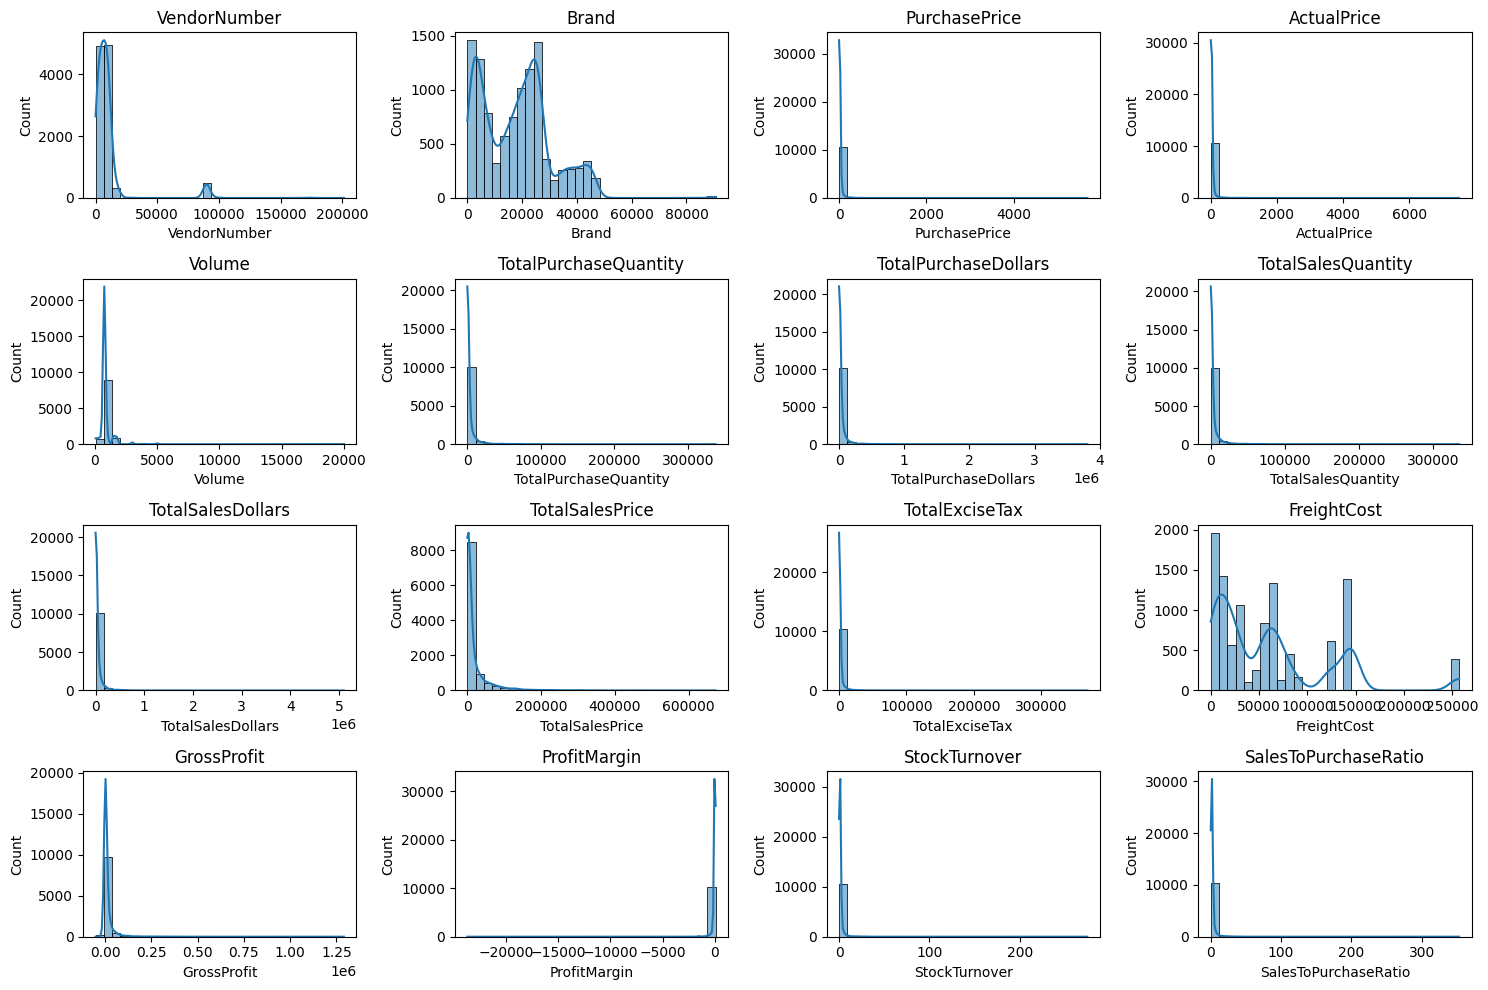

In [49]:
# distribution plots for numerical columns
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.histplot(df[col],kde=True,bins=30)
  plt.title(col)
plt.tight_layout()
plt.show()

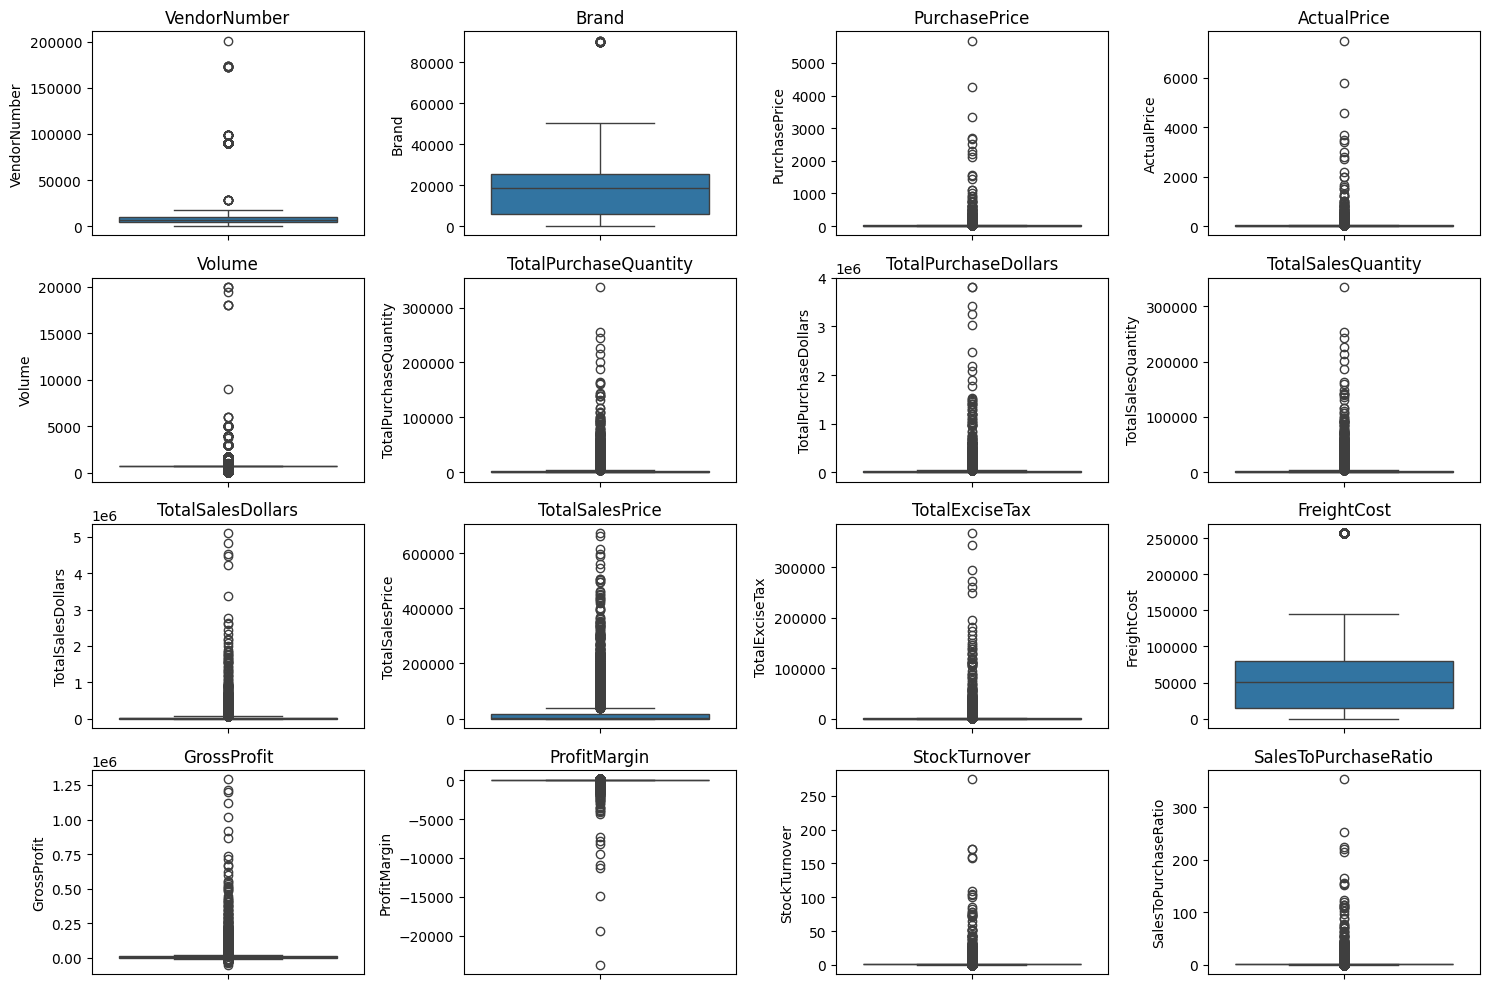

In [50]:
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.boxplot(y=df[col])
  plt.title(col)
plt.tight_layout()
plt.show()

**Summary Statistics Insights:**

**Negative & Zero Values:**

*   Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price.
*   Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.

*   Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

**Outliers Indicated by High Standard Deviations:**



*   Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
*   Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.

*   Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.











In [51]:
df=pd.read_sql_query(
    """ SELECT * FROM vendor_sales_summary
    WHERE GrossProfit>0 AND ProfitMargin>0 AND TotalSalesQuantity>0""",conn
)

In [52]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
8561,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
8562,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
8563,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


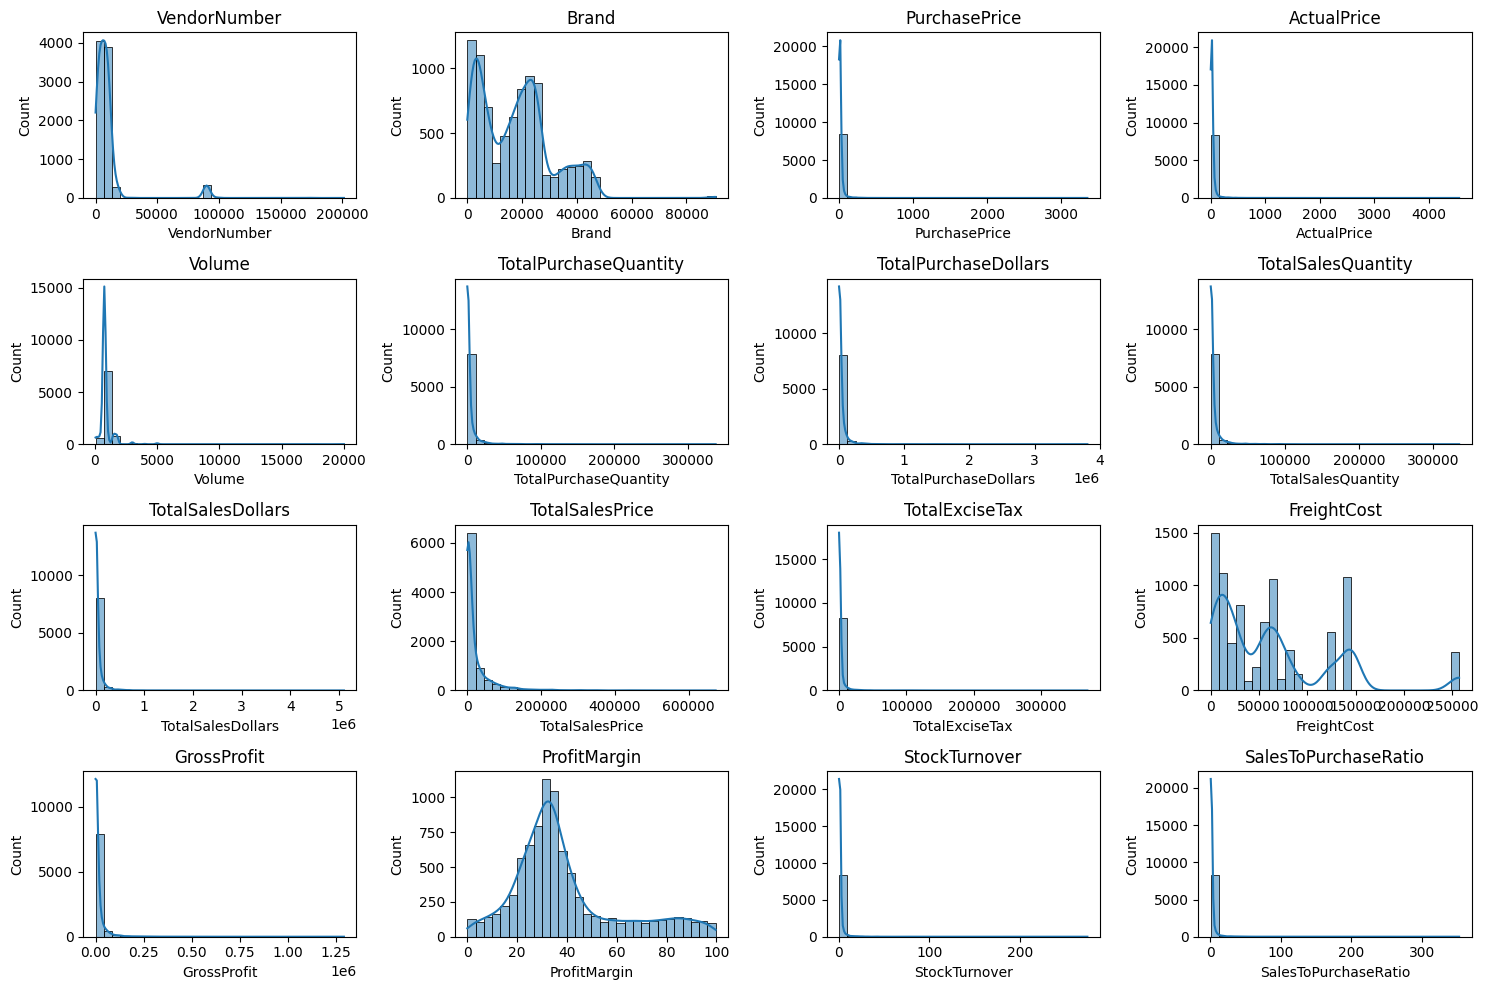

In [53]:
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.histplot(df[col],kde=True,bins=30)
  plt.title(col)
plt.tight_layout()
plt.show()

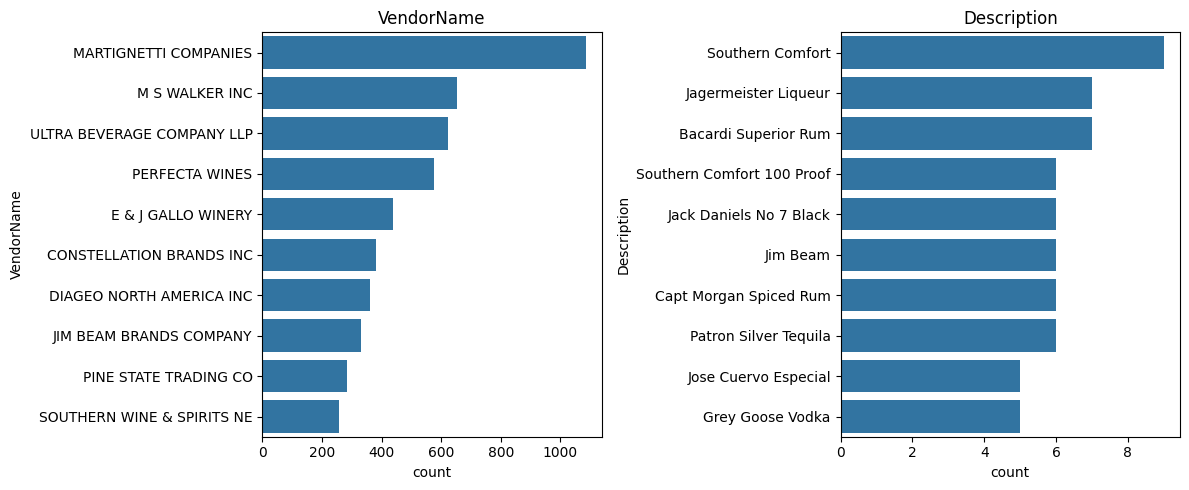

In [54]:
categorical_cols=["VendorName","Description"]
plt.figure(figsize=(12,5))
for i ,col in enumerate(categorical_cols):
  plt.subplot(1,2,i+1)
  sns.countplot(df[col],order=df[col].value_counts().index[:10])
  plt.title(col)
plt.tight_layout()
plt.show()
 #for top 10

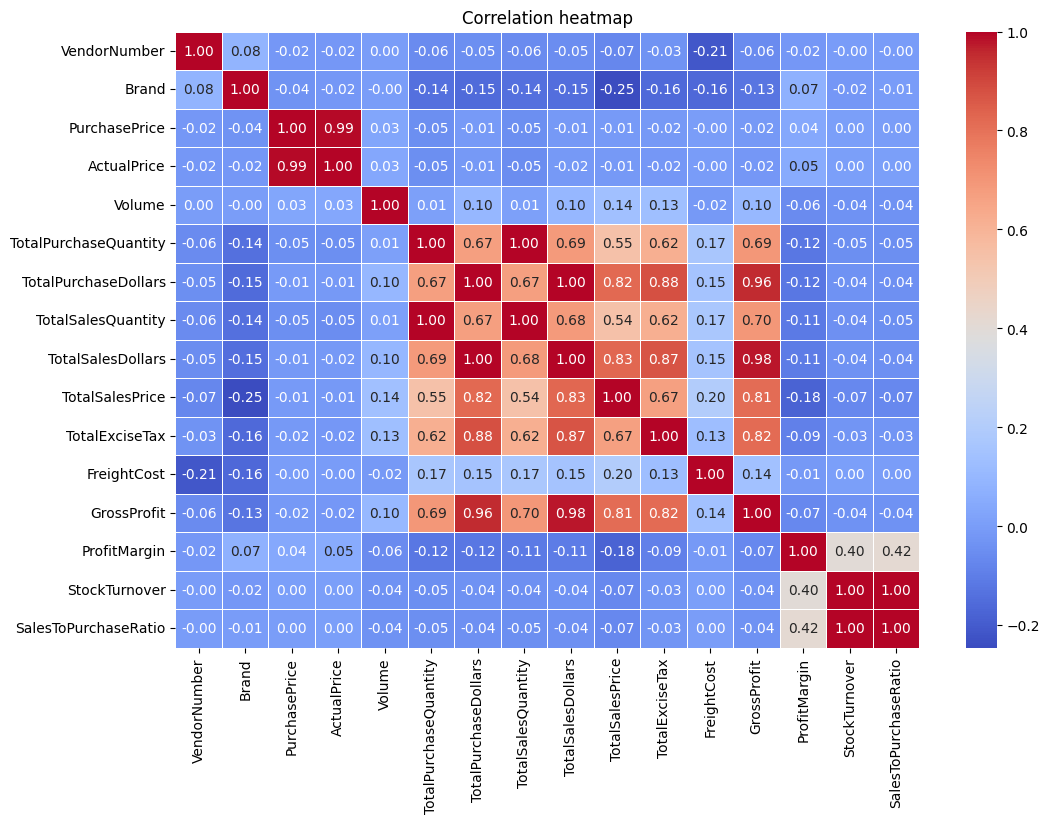

In [55]:
#heatmap to plot corr btw 2 numerical variables
plt.figure(figsize=(12,8))
correlation_matrix=df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)
plt.title("Correlation heatmap")
plt.show()


**correlation insights**


*   purchase price has weak correlation with totalsalesdollars(-0.012) and grossprofit(-0.016),suggesting that price variations do not significantly impact sales revenue or profit.
*   Strong correlation between TotalPurchaseQuantity and TotalSalesQuantity (0.999), confirming efficient inventory turnover.


*   Negative correlation between ProfitMargin & TotalSalesPrice (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
*   StockTurnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily lead to higher profitability.




DATA ANALYSIS

Identify brands that needs promotional or pricing adjustments which exhibits lower sales performace but higher profit margins

In [99]:
brand_performance=df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'


}).reset_index()

In [100]:
low_sales_threshold=brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold=brand_performance['ProfitMargin'].quantile(0.85)


In [101]:
low_sales_threshold

np.float64(560.299)

In [102]:
high_margin_threshold

np.float64(64.97017552750111)

In [103]:
#filter brands with low sales but high profit margins
target_brands=brand_performance[
    (brand_performance['TotalSalesDollars']<low_sales_threshold) &
    (brand_performance['ProfitMargin']>high_margin_threshold)
]
print("Brands with low sales but high profit margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with low sales but high profit margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


so these type of brands need promotions and pricing adjustments

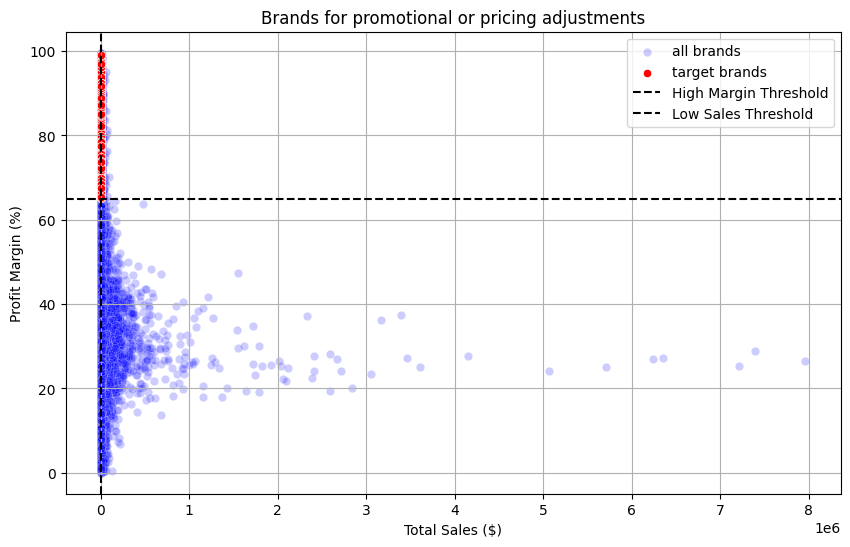

In [104]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance,x='TotalSalesDollars',y='ProfitMargin',color="blue",label="all brands",alpha=0.2)
sns.scatterplot(data=target_brands,x='TotalSalesDollars',y='ProfitMargin',color="red",label="target brands")
plt.axhline(y=high_margin_threshold,linestyle='--',color='black',label="High Margin Threshold")
plt.axvline(x=low_sales_threshold,linestyle='--',color='black',label="Low Sales Threshold")
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for promotional or pricing adjustments")
plt.legend()
plt.grid(True)
plt.show()

In [105]:
brand_performance=brand_performance[brand_performance['TotalSalesDollars']<10000]

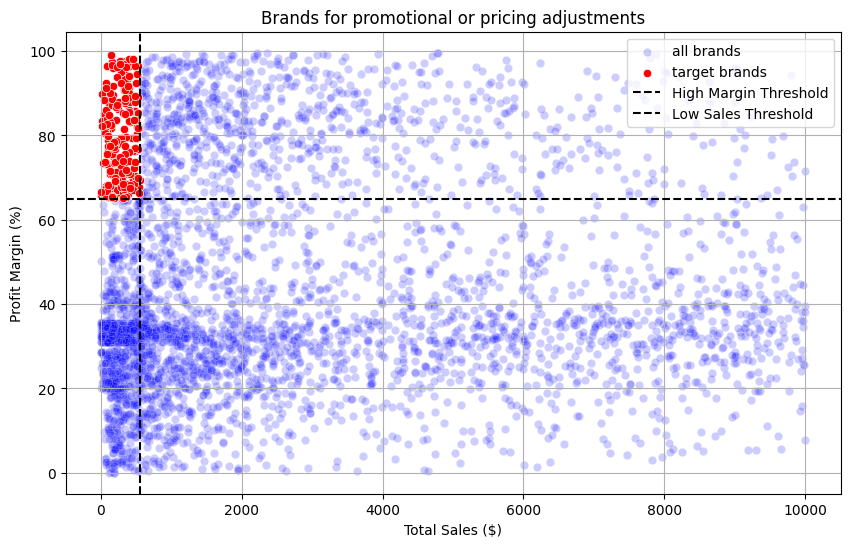

In [106]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance,x='TotalSalesDollars',y='ProfitMargin',color="blue",label="all brands",alpha=0.2)
sns.scatterplot(data=target_brands,x='TotalSalesDollars',y='ProfitMargin',color="red",label="target brands")
plt.axhline(y=high_margin_threshold,linestyle='--',color='black',label="High Margin Threshold")
plt.axvline(x=low_sales_threshold,linestyle='--',color='black',label="Low Sales Threshold")
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for promotional or pricing adjustments")
plt.legend()
plt.grid(True)
plt.show()

which vendors and brands demonstrate the highest sales performace

In [107]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [108]:
# Top Vendors & Brands by Sales Performance
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)
top_vendors

,TotalSalesDollars
VendorName,
DIAGEO NORTH AMERICA INC,6.799010e+07
MARTIGNETTI COMPANIES,3.933036e+07
PERNOD RICARD USA,3.206320e+07
JIM BEAM BRANDS COMPANY,3.142302e+07
BACARDI USA INC,2.485482e+07
CONSTELLATION BRANDS INC,2.421875e+07
E & J GALLO WINERY,1.839990e+07
BROWN-FORMAN CORP,1.824723e+07
ULTRA BEVERAGE COMPANY LLP,1.650254e+07


In [64]:
top_vendors=df.groupby('VendorName')["TotalSalesDollars"].sum().nlargest(10)
top_brands=df.groupby('Description')["TotalSalesDollars"].sum().nlargest(10)
top_vendors

,TotalSalesDollars
VendorName,
DIAGEO NORTH AMERICA INC,6.799010e+07
MARTIGNETTI COMPANIES,3.933036e+07
PERNOD RICARD USA,3.206320e+07
JIM BEAM BRANDS COMPANY,3.142302e+07
BACARDI USA INC,2.485482e+07
CONSTELLATION BRANDS INC,2.421875e+07
E & J GALLO WINERY,1.839990e+07
BROWN-FORMAN CORP,1.824723e+07
ULTRA BEVERAGE COMPANY LLP,1.650254e+07


In [109]:
top_vendors.apply(lambda x:format_dollars(x))

,TotalSalesDollars
VendorName,
DIAGEO NORTH AMERICA INC,67.99M
MARTIGNETTI COMPANIES,39.33M
PERNOD RICARD USA,32.06M
JIM BEAM BRANDS COMPANY,31.42M
BACARDI USA INC,24.85M
CONSTELLATION BRANDS INC,24.22M
E & J GALLO WINERY,18.40M
BROWN-FORMAN CORP,18.25M
ULTRA BEVERAGE COMPANY LLP,16.50M


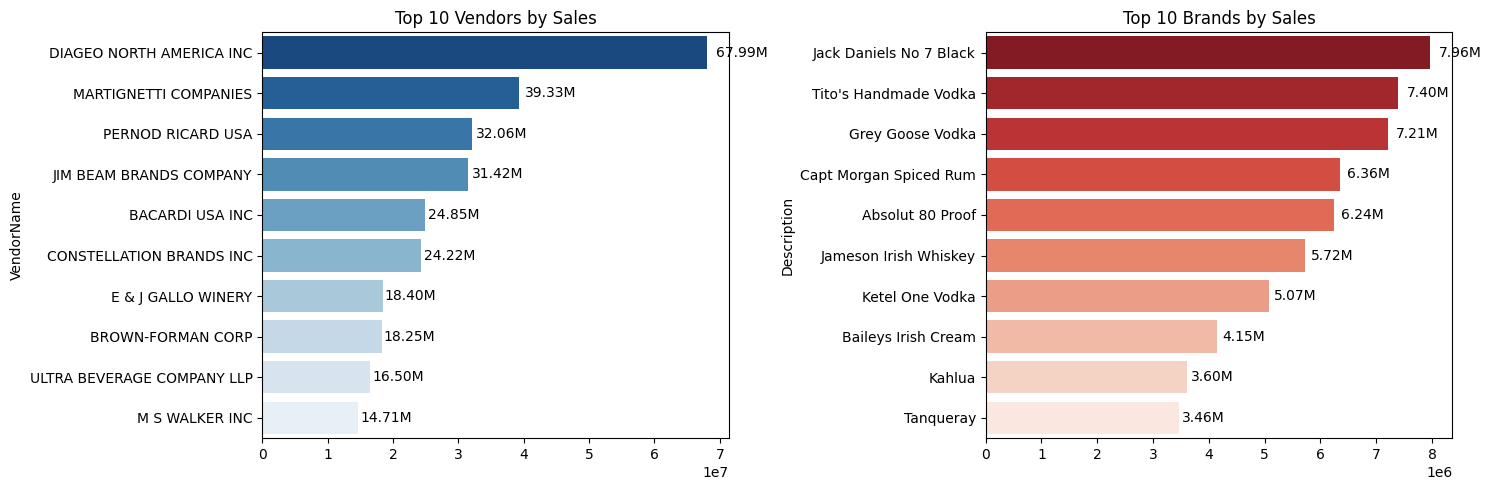

In [110]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

which vendors contribute the most to total purchase dollars?

In [112]:
# Rank Vendors by Total Purchase Dollars
vendor_performance = df.groupby("VendorName").agg({
    "TotalPurchaseDollars": "sum",
    "GrossProfit": "sum",
    "TotalSalesDollars":"sum"
}).reset_index()

# Calculate Contribution % to Overall Procurement
vendor_performance["Purchase_Contribution%"] = (vendor_performance["TotalPurchaseDollars"] / vendor_performance["TotalPurchaseDollars"].sum()) * 100

# Rank Vendors by Total Purchase Dollars & Profitability
vendor_performance = round(vendor_performance.sort_values(by="TotalPurchaseDollars", ascending=False),2)

# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


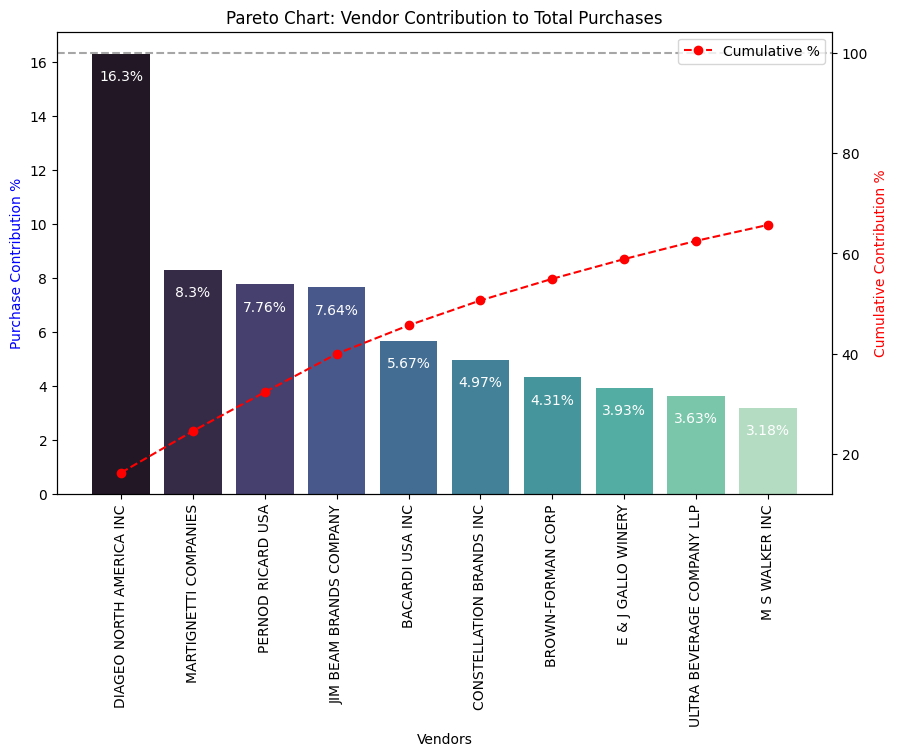

In [113]:
top_vendors['Cumulative_Contribution%'] = top_vendors['Purchase_Contribution%'].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['Purchase_Contribution%'],  palette="mako", ax=ax1)

for i, value in enumerate(top_vendors['Purchase_Contribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative %')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

How much of total procurement is dependent on the top vendors?

Total Purchase Contribution of top 10 vendors is 65.69 %


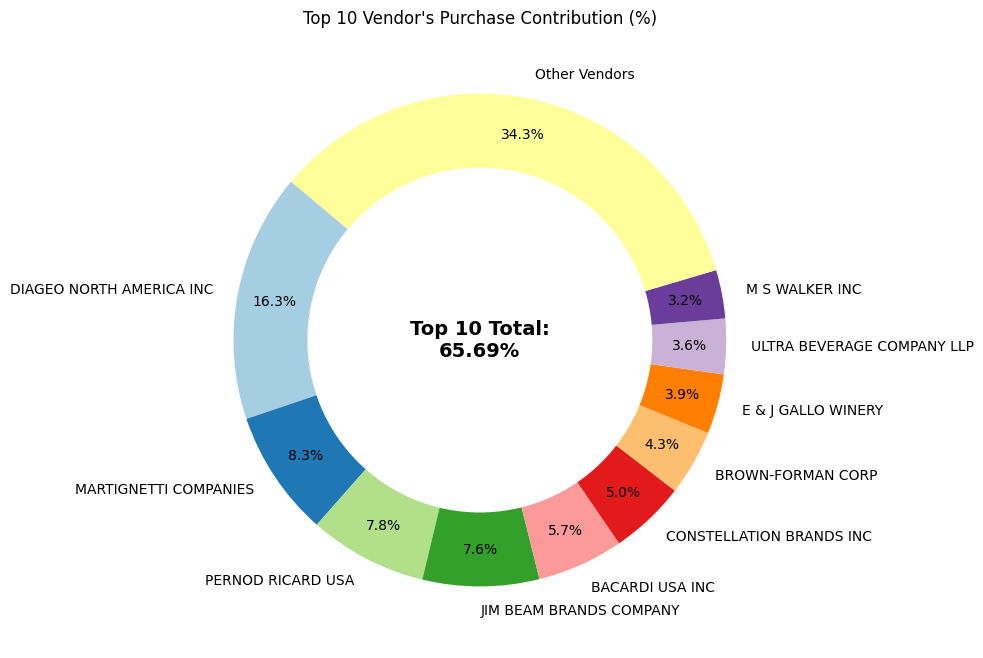

In [114]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['Purchase_Contribution%'].sum(),2)} %")

vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['Purchase_Contribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

The remaining vendors contribute only 34.31%, meaning they are not utilized effectively or may not be as competitive. If vendor dependency is too high, consider identifying new suppliers to reduce risk.

**Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?**

In [115]:
# Calculate Unit Purchase Price per Vendor & Volume Group
df["UnitPurchasePrice"] = df["TotalPurchaseDollars"] / df["TotalPurchaseQuantity"]


In [116]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio,UnitPurchasePrice
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647,26.27
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830,23.19
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594,18.24
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493,16.17
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667,1.32
8561,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829,0.39
8562,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838,0.74
8563,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388,1.47


In [117]:
# Group by Order Sizes (e.g., Small, Medium, Large Purchases)
df["OrderSize"] = pd.qcut(df["TotalPurchaseQuantity"], q=3, labels=["Small", "Medium", "Large"])


In [118]:
df["OrderSize"]

,OrderSize
0,Large
1,Large
2,Large
3,Large
4,Large
...,...
8560,Small
8561,Small
8562,Small
8563,Small


In [119]:
# Analyze Cost Savings per Order Size
bulk_purchase_analysis = df.groupby("OrderSize")["UnitPurchasePrice"].mean().reset_index()
print(bulk_purchase_analysis)

  OrderSize  UnitPurchasePrice
0     Small          39.057543
1    Medium          15.486414
2     Large          10.777625


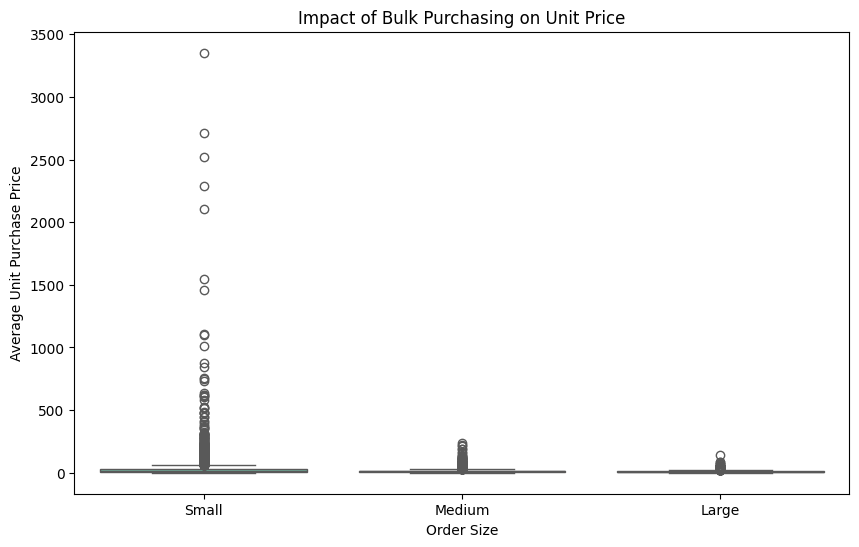

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()



*   Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
*  The price difference between Small and Large orders is substantial (~72% reduction in unit cost)

*  This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.






**Which vendors have low inventory turnover, indicating excess stock and slow-moving products?**

In [121]:
# Identify Low Inventory Turnover Vendors
low_turnover_vendors = df[df["StockTurnover"] < 1].groupby("VendorName")["StockTurnover"].mean().reset_index()

# Sort by Lowest Turnover
low_turnover_vendors = low_turnover_vendors.sort_values(by="StockTurnover", ascending=True)
low_turnover_vendors.head(10)

,VendorName,StockTurnover
0,ALISA CARR BEVERAGES,0.615385
36,HIGHLAND WINE MERCHANTS LLC,0.708333
60,PARK STREET IMPORTS LLC,0.751306
19,Circa Wines,0.755676
26,Dunn Wine Brokers,0.766022
15,CENTEUR IMPORTS LLC,0.773953
78,SMOKY QUARTZ DISTILLERY LLC,0.783835
90,TAMWORTH DISTILLING,0.797078
91,THE IMPORTED GRAPE LLC,0.807569
101,WALPOLE MTN VIEW WINERY,0.820548


Slow-moving inventory increases holding costs (warehouse rent, insurance, depreciation)
Identifying vendors with low inventory turnover is critical for business efficiency, cost reduction, and profitability

**How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?**

In [122]:
# Calculate Unsold Inventory Value
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))

# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

Total Unsold Capital: 2.71M


,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


**What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors.**

In [123]:
# Define top and low vendors based on Total Sales Dollars (Top 25% & Bottom 25%)
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)


In [124]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()


In [125]:
# Function to compute confidence interval
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


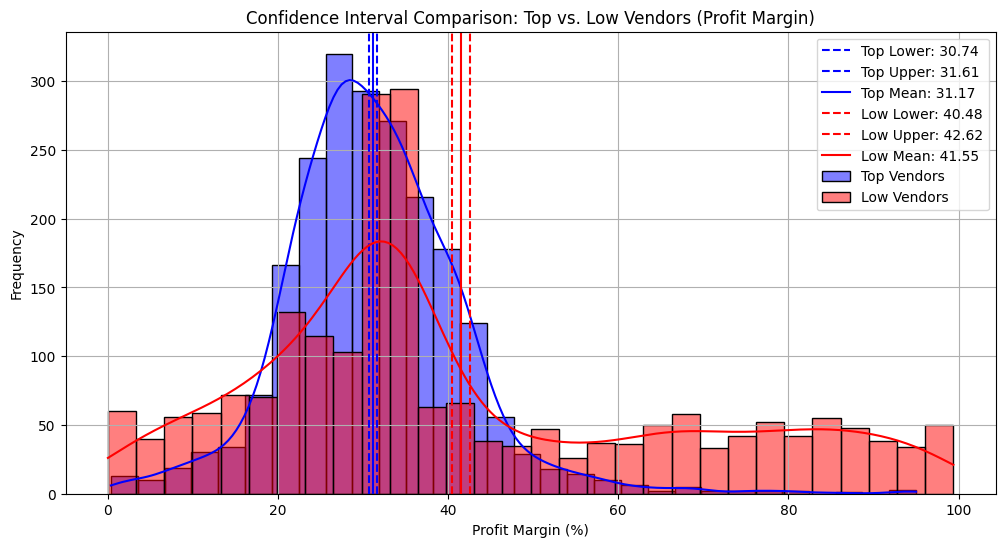

In [126]:
# Compute confidence intervals
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()



*   The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
*   This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.

*   For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
*   For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies





**Is there a significant difference in profit margins between top-performing and low-performing vendors?**

Hypothesis:

H₀ (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.

H₁ (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [127]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")

T-Statistic: -17.6440, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.




*  A p-value this small suggests that the difference is not just statistically significant but also practically meaningful.
*   The two vendor groups operate very differently in terms of profitability.

